> # Using model from Keras

We don't have to realize standard model. We can call pre-trained model in **keras.applications** by one code. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import warnings ; warnings.filterwarnings("ignore")

In [2]:
model = keras.applications.resnet50.ResNet50(weights="imagenet")

This code makes ResNet-50 model and download the weights which are trained by imagenet data. 224X224 size image should be input. So we have to change image's size.

In [3]:
from sklearn.datasets import load_sample_image

china = load_sample_image("china.jpg")/255
flower = load_sample_image("flower.jpg")/255
images = np.array([china, flower])
batch_size, height, width, channel = images.shape

In [4]:
images_resized = tf.image.resize(images, [224, 224])

(-0.5, 223.5, 223.5, -0.5)

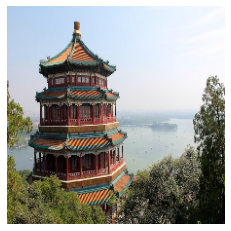

In [5]:
plt.imshow(images_resized[0])

plt.axis("off")

The model suppose that an image is preprocessed by proper method. The input value is 0 to 1 or -1 to 1. So each model provides **preprocess_input()** function. The pixel value for this function should be 0 to 255.

In [6]:
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)

In [7]:
y_proba = model.predict(inputs)

**y_proba** has one image row and 1000 class column. To get top n class name and probability, use **decode_predictions()** function.

In [8]:
top_proba = keras.applications.resnet50.decode_predictions(y_proba, top=3)

for i in range(len(images)):
    for class_id, name, prob in top_proba[i]:
        print("{} - {:12s} {:.2f}%".format(class_id, name, prob * 100))
    print()

n02825657 - bell_cote    82.35%
n03877845 - palace       6.75%
n03781244 - monastery    4.19%

n03530642 - honeycomb    49.83%
n13040303 - stinkhorn    33.96%
n02206856 - bee          4.35%



And there are other models like Xception or GoogLNet in **keras.application** package.

#### Transfer Training

To train image classification model by insufficient data, it is good to use low level layers of pre-trianed model. Let's use Xception model.

In [9]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)
data_size = info.splits["train"].num_examples
class_names = info.features["label"].names
n_classes = info.features["label"].num_classes

We cna get information of dataset if we set **with_info=True**. This dataset has only train set. So we should devide it. 

In [10]:
train_set, valid_set, test_set = tfds.load( name="tf_flowers", 
                                                split=('train[:75%]', 'train[10%:75%]', 'train[10%:]'), 
                                                as_supervised=True)

And we should change image size again.

In [11]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

Shuffle trainset and apply preprocessing function to 3 dataset. Then set batch size and apply prepatch.

In [12]:
batch_size = 32
train_set = train_set.shuffle(1000)
train_set = train_set.map(preprocess).batch(batch_size).prefetch(1)
valid_set = valid_set.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set.map(preprocess).batch(batch_size).prefetch(1)

Then load trianed Xception model. Except global average pooling layer and output dense layer at top by **include_top=False**. And add new global average pool and output dense layer with softmax function.

In [13]:
base_model = keras.applications.xception.Xception(weights="imagenet", include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.Model(inputs=base_model.input, outputs=output)

Freeze trained layer first n step.

In [14]:
for layer in base_model.layers:
    layer.trainable = False

In [15]:
optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model.fit(train_set, epochs=5, validation_data=valid_set)

Epoch 1/5
86/86 [==============================] - 426s 5s/step - loss: 1.7564 - accuracy: 0.7896 - val_loss: 0.7106 - val_accuracy: 0.8927
Epoch 2/5
86/86 [==============================] - 429s 5s/step - loss: 0.5273 - accuracy: 0.9044 - val_loss: 0.2503 - val_accuracy: 0.9409
Epoch 3/5
86/86 [==============================] - 406s 5s/step - loss: 0.2293 - accuracy: 0.9422 - val_loss: 0.1525 - val_accuracy: 0.9577
Epoch 4/5
86/86 [==============================] - 371s 4s/step - loss: 0.1561 - accuracy: 0.9593 - val_loss: 0.0750 - val_accuracy: 0.9799
Epoch 5/5
86/86 [==============================] - 381s 4s/step - loss: 0.0950 - accuracy: 0.9735 - val_loss: 0.0552 - val_accuracy: 0.9845


In [ ]:
for layer in base_model.layers:
    layer.trainable = True
    
optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model.fit(train_set, epochs=27, validation_data=valid_set)